In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import transforms
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 

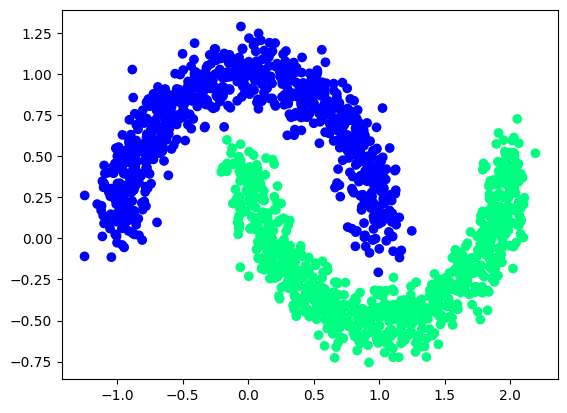

In [151]:
#data 불러오기
x, y = make_moons(n_samples=2000, noise=0.1)

#train, test split 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

# plot 
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.winter)

In [152]:
y_train.shape

(1600,)

# Custom Dataset

In [153]:
# Dataset 상속
class train_labeled_set(Dataset): 
  def __init__(self,x,y,transform):
    self.x_train_labeled = x[:1200]
    self.y_train_labeled = y[:1200]
    
  def __len__(self): 
    return len(self.x_train_labeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_train_labeled[idx:idx+1]).view(-1, )
    temp2 = torch.Tensor(self.y_train_labeled[idx:idx+1]).view(-1, )
    
    return temp1, temp2

class train_unlabeled_set(Dataset):
  def __init__(self,x,y,transform):
    self.x_train_unlabeled = x[1200:]
    
  def __len__(self): 
    return len(self.x_train_unlabeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_train_unlabeled[idx:idx+1]).view(-1, )
  
    return temp1


class test_labeled_set(Dataset): 
  def __init__(self,x,y):
    self.x_test_labeled = x
    self.y_test_labeled = y
    
  def __len__(self): 
    return len(self.x_test_labeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_test_labeled[idx:idx+1]).view(-1, )
    temp2 = torch.Tensor(self.y_test_labeled[idx:idx+1]).view(-1, )
    
    return temp1, temp2


In [154]:
# Noise Function
def noise_fn1(x): 
    mu =0.0
    sigma = 1.0

    if x.shape[0]==32: 
        noise = torch.normal(mean = mu ,std = sigma, size =(32,2))
    else : 
        noise = torch.normal(mean = mu ,std = sigma, size =(x.shape[0],2))
        
   
    return x+noise


# Hyper-parameter

In [155]:
input_size = 2
hidden_size = 10
output_size = 1
BATCH_SIZE = 32
EPOCHS = 1400
DEVICE = 'mps'
lr= 0.001
K=2
T=0.5

# DataLoader

In [156]:
train_labeled_set=train_labeled_set(x_train,y_train,noise_fn1)
train_labeled_Dataloader = DataLoader(train_labeled_set, batch_size=BATCH_SIZE, shuffle=True,)
train_unlabeled_set=train_unlabeled_set(x_train,y_train,noise_fn1)
train_unlabeled_Dataloader = DataLoader(train_unlabeled_set,batch_size=BATCH_SIZE, shuffle=True,)
test_labeled_set = test_labeled_set(x_test,y_test)
test_labeled_Dataloader = DataLoader(test_labeled_set,batch_size=BATCH_SIZE,shuffle=True,)

In [157]:
x, y  = next(iter(train_labeled_Dataloader))
print(x.shape)
print(y.shape)

torch.Size([32, 2])
torch.Size([32, 1])


In [158]:
z = next(iter(train_unlabeled_Dataloader))
print(z.shape)


torch.Size([32, 2])


# Model

In [159]:
class NET(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.NN =nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.NN(x)

In [160]:
model = NET(input_size,hidden_size,output_size)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

# TRAIN

In [161]:
losses = []
for epoch in range(EPOCHS):
    model.train()
    cost = 0.0


    for i in range(len(train_labeled_Dataloader)):
        input_x, input_y = next(iter(train_labeled_Dataloader))
        input_u = next(iter(train_unlabeled_Dataloader))
        print(i, input_x.shape)
        print()
        new_x = noise_fn1(input_x)
        u = [noise_fn1(input_u) for _ in range(K)]
        q = sum(map(lambda i: model(i), u)) / K
        Ux = torch.Tensor(np.concatenate(u, axis=0))
        Uy = torch.Tensor(np.concatenate([q.detach().numpy() for _ in range(K)], axis=0))
        optimizer.zero_grad()
            
        output1 = model(new_x)
        output2 = model(Ux)
        loss = criterion1(output1,input_y) + criterion2(output2,Uy)
        loss.backward()
        optimizer.step()

        cost = cost + loss.item()

    cost  = cost / len(train_labeled_Dataloader)
    losses.append(cost)
    if (epoch + 1) % 30 == 0:
        print(f"Training Epoch : {epoch+1:1d}, training loss : {cost:.3f}")


Training Epoch : 30, training loss : 0.679
Training Epoch : 60, training loss : 0.666
Training Epoch : 90, training loss : 0.655
Training Epoch : 120, training loss : 0.628
Training Epoch : 150, training loss : 0.619
Training Epoch : 180, training loss : 0.608
Training Epoch : 210, training loss : 0.597
Training Epoch : 240, training loss : 0.579
Training Epoch : 270, training loss : 0.559
Training Epoch : 300, training loss : 0.566
Training Epoch : 330, training loss : 0.600
Training Epoch : 360, training loss : 0.573
Training Epoch : 390, training loss : 0.593
Training Epoch : 420, training loss : 0.559
Training Epoch : 450, training loss : 0.566
Training Epoch : 480, training loss : 0.565
Training Epoch : 510, training loss : 0.580
Training Epoch : 540, training loss : 0.570
Training Epoch : 570, training loss : 0.574
Training Epoch : 600, training loss : 0.576
Training Epoch : 630, training loss : 0.555
Training Epoch : 660, training loss : 0.562
Training Epoch : 690, training loss

Text(0, 0.5, 'loss')

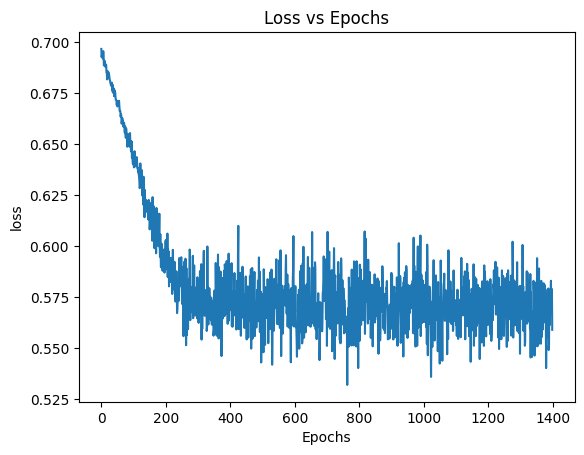

In [162]:
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

### TEST


[[False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]]
test_loss: 0.499, test_acc: 0.812

[[False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]]
test_loss: 0.499, test_acc: 0.750

[[ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]]
test_loss: 0.499, test_acc: 0.812

[[False]
 [ True]
 [False]


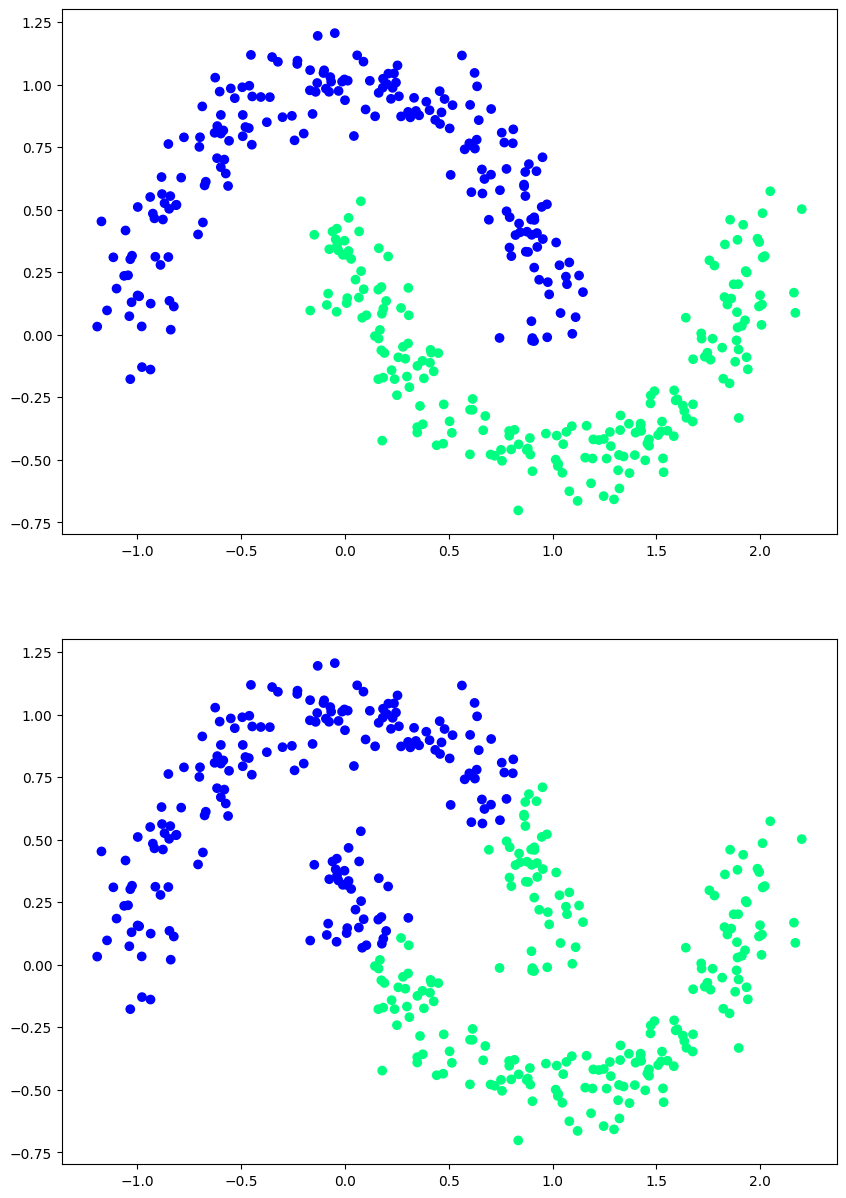

In [163]:
from sklearn.metrics import accuracy_score

model.eval()
y_true = []
y_pred = []

plt.figure(figsize=(10,15))
# set the requires_grad flag to false as we are in the test mode
with torch.no_grad():
    for _, (data, target) in enumerate(test_labeled_Dataloader):
        # moving the tensors to the configured device
        data, target = data , target

        # the model on the data
        output = model(data)
        print()
        #PREDICTIONS
        pred = output.data.cpu().numpy()>0.5
        print(pred)
        test_loss = loss.item()
        test_acc = accuracy_score(target, pred)
        print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss,test_acc))
        plt.subplot(211)
        plt.scatter(data[:,0], data[:,1], c=target, cmap=plt.cm.winter)

        plt.subplot(212)
        plt.scatter(data[:,0], data[:,1], c=pred, cmap=plt.cm.winter)

        

In [130]:
pred

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])